# Onset detection tutorial

This tutorial shows how to perform the task of onset detection with `madmom`. It assumes that you have finished/understood the [audio_signal_handling notebook](./audio_signal_handling.ipynb), since that notebook explains some of the basic design principles and usage patterns.

In [1]:
%matplotlib inline

import madmom
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import maximum_filter

As an example, the `SuperFlux` onset detection algorithm is used for this tutorial. It is based on the well known spectral flux algorithm, so we do this first. The spectral flux is defined as the sum (or mean) of the first order differences of the magnitude spectrogram of an audio file:

In [2]:
# use madmom to get the spectrogram (see previous tutorial)
spec = madmom.audio.spectrogram.Spectrogram('data/sample.wav')

Then you can either continue manually:

In [3]:
# calculate the difference
diff = np.diff(spec, axis=0)
# keep only the positive differences
pos_diff = np.maximum(0, diff)
# sum everything to get the spectral flux
sf = np.sum(pos_diff, axis=1)

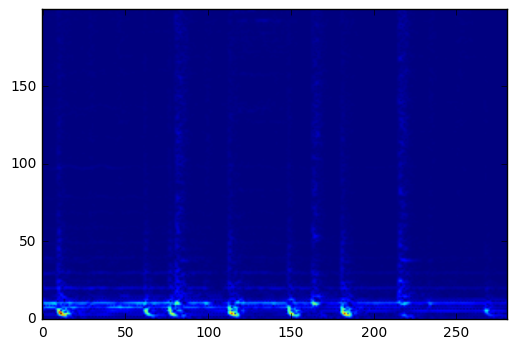

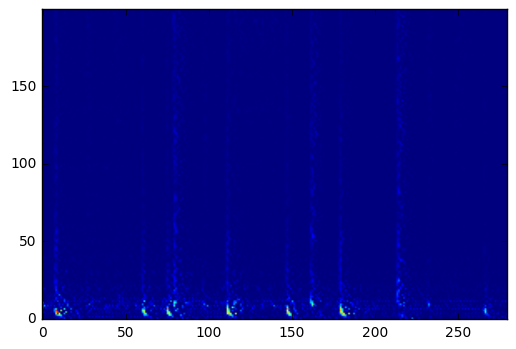

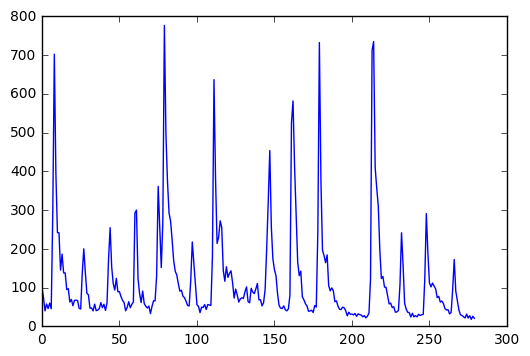

In [4]:
plt.figure()
plt.imshow(spec[:, :200].T, origin='lower', aspect='auto')
plt.figure()
plt.imshow(pos_diff[:, :200].T, origin='lower', aspect='auto')
plt.figure()
plt.plot(sf)


Or you can use the features provided by `madmom` to do the same just easier:

In [5]:
sf = madmom.features.onsets.spectral_flux(spec)

Spectral flux works quite well for onset detection, but to make this tutorial a bit more interesting, we add the `SuperFlux` stuff.

First of all, the `SuperFlux` does not use the linearly spaced magnitude spectrogram, but rather one that is filtered logarithmically (with 24 bands per octave). `madmom` provides a convenience class `FilteredSpectrogram` which does exactly this. It expects a `Spectrogam` and a `Filterbank` instance or class as input. We simply pass the number of bands as an additional argument. Please note that the parameter which sets the number of bands 'num_bands' is always named 'num_bands', independently whether it represents the total number of bands (as for a `MelFilterbank`) or bands per octave (as for the `LogFilterbank`).

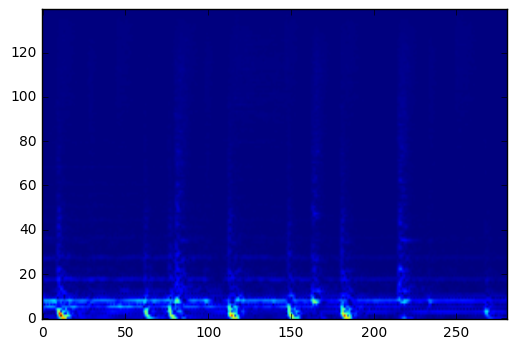

In [6]:
filt_spec = madmom.audio.spectrogram.FilteredSpectrogram(spec, filterbank=madmom.audio.filters.LogFilterbank,
                                                         num_bands=24)
plt.imshow(filt_spec.T, origin='lower', aspect='auto')

To better match the perception of loudness of humans, the filtered spectrogram is also scaled logarithmically (after adding a constant value of 1 to avoid negative values).

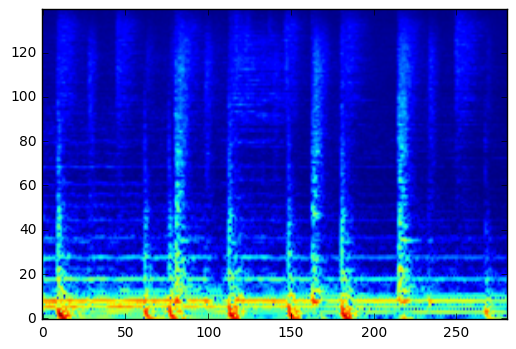

In [9]:
log_spec = madmom.audio.spectrogram.LogarithmicSpectrogram(filt_spec, add=1)

plt.imshow(log_spec.T, origin='lower', aspect='auto')

Contrary to the spectral flux which uses the temporal evolution of the magnitudes (i.e. calculate difference), the difference is not calculated relative to the same spectrogram, but rather a maximum filtered version thereof.
The effect of this step is that peaks are "widened" in frequency direction.

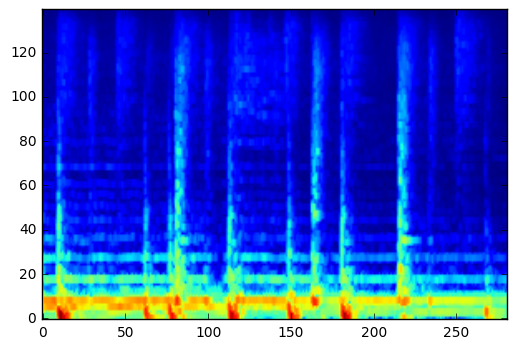

In [10]:
# maximum filter size spreads over 3 frequency bins
size = (1, 3)
max_spec = maximum_filter(log_spec, size=size)
plt.imshow(max_spec.T, origin='lower', aspect='auto')

Now we continue to calculate the difference w.r.t. this "widened" spectrogram.

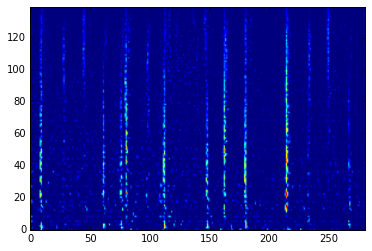

In [9]:
# init the diff array
diff = np.zeros_like(log_spec)
# calculate the difference between the log. spec and the max. filtered version thereof
diff[1:] = (log_spec[1:] - max_spec[: -1])
# then continue as with the spectral flux, i.e. keep only the positive differences
pos_diff = np.maximum(0, diff)

plt.figure()
plt.imshow(pos_diff.T, origin='lower', aspect='auto')

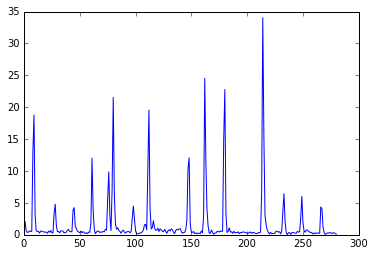

In [10]:
# sum everything to get the onset detection function
superflux = np.sum(pos_diff, axis=1)

plt.figure()
plt.plot(superflux)

To achieve the same with `madmom`, some classes have some of the needed functionality already built in for convienience. E.g. the `LogarithmicFilteredSpectrogram` does all the filtering and scaling combined in a single class (accepting a `STFT`, `FramedSignal`, `Signal` object or a file name as input). Appropriate arguments can be given and the ones not understood by the class are passed if there's the need to instantiate an object up the hierarchy.

In [11]:
log_filt_spec = madmom.audio.spectrogram.LogarithmicFilteredSpectrogram('data/sample.wav', num_bands=24)

The `SpectrogramDifference` class calculates the first order difference of a spectrogram. It accepts a couple of parameters, such as `diff_frames` to set the number of frames how far apart the difference should be calculated, and adds functionality to perform maximum filtering (via `diff_max_bins`) or returning only positive differences (via `positive_diffs`).
For convienience, the resulting difference spectrogram has the same shape as the given one (`np.diff()` does not), with all frames < `diff_frames` set to zero.

In [12]:
# this is the same as before:
superflux_diff = madmom.audio.spectrogram.SpectrogramDifference(log_filt_spec, positive_diffs=True, diff_max_bins=3)
superflux_2 = np.sum(superflux_diff, axis=1)

Of course, the same functionality can be found as `madmom.features.onsets.superflux()`. The function implements the maximum filtering, but the user has to pass an spectrogram obtained with appropriate parameters to make the function work as desired.

In [13]:
superflux_3 = madmom.features.onsets.superflux(log_filt_spec)

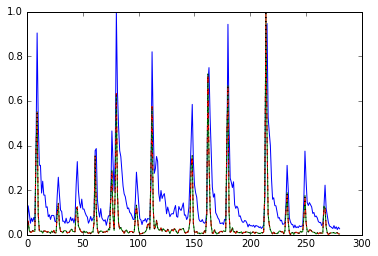

In [14]:
# we scale them to have the same range
plt.figure()
plt.plot(sf / sf.max(), 'b')  # blue
plt.plot(superflux / superflux.max(), 'g')  # green
plt.plot(superflux_2 / superflux_2.max(), 'r--')  # dashed red
plt.plot(superflux_3 / superflux_3.max(), 'k:')  # dotted black

You can see that the `SuperFlux` function has sharper peaks and a lower overall noise floor as compared to the normal spectral flux, which makes it easier to detect the peaks.